In [1]:
# importing libraries & dependencies
!pip install vaderSentiment
!pip install nltk
!pip install textblob
!pip install fbprophet
from google.colab import drive
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob
import string
from string import digits
from fbprophet import Prophet
from fbprophet.plot import plot_cross_validation_metric
from sklearn.metrics import mean_squared_error
from fbprophet.diagnostics import cross_validation

     |████████████████████████████████| 133kB 5.7MB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


Data: -
1. News Headlines (DataFrame -> combined_df)
    
    Scrapped from https://www.investing.com/equities/google-inc-c-news
2. Historical data (DataFrame -> historical_df)
    
    Downloaded from https://in.finance.yahoo.com/quote/GOOG/history?p=GOOG

In [3]:
data = pd.read_csv("/content/drive/MyDrive/Tech_Tailored/final_goog_headlines.csv")
data.drop(columns=['Unnamed: 0'], inplace= True)
data.rename(columns={'Published_on':'Date'}, inplace=True)
data.Date = data.Date.astype('datetime64[ns]')
data.head()

,Headlines,Date
0,Exclusive: U.S. agency probes Facebook for 'sy...,2021-03-06
1,Biden adds Big Tech critic Tim Wu to his econo...,2021-03-06
2,Hackers target Williams F1 livery launch on AR...,2021-03-06
3,"Watch Amazon, Facebook, Google as White House ...",2021-03-06
4,The Trade Desk stock drops 20% in two days aft...,2021-03-06


Concatenating all the headlines for all the unique dates

In [4]:
combined_df = data.groupby(['Date'])['Headlines'].apply(', '.join).reset_index()
print(combined_df,type(combined_df))

          Date                                          Headlines
0   2018-11-20  Wall Street tumbles as Apple, internet stocks ...
1   2018-11-23  Exclusive: Logitech in talks to acquire headph...
2   2018-11-28  Google workers demand end to censored Chinese ...
3   2018-11-29  Indonesia's Go-Jek starts trial launch in Sing...
4   2018-11-30  White House to hold roundtable with tech execu...
..         ...                                                ...
363 2021-03-01  Coinbase and Roblox take a page from Google, k...
364 2021-03-02  Dow Racks Up Triple-Digit Gains as Bulls Raise...
365 2021-03-03  S&P 500 Slips on Tech Tumble After Monday's Ra...
366 2021-03-04  2021 Healthcare Reputation Report Correlates S...
367 2021-03-06  Exclusive: U.S. agency probes Facebook for 'sy...

[368 rows x 2 columns] <class 'pandas.core.frame.DataFrame'>


### Sentiment Analysis

Text Cleaning 

In [5]:
# cleaning text
combined_df['Headlines'] = combined_df['Headlines'].apply(lambda x: x.lower())

# set of special characters
exclude = set(string.punctuation)
combined_df['Headlines'] = combined_df['Headlines'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

# removing the digits from the text
#remove_digits = str.maketrans('', '', digits)
#data['Headlines'] = data['Headlines'].apply(lambda x: x.translate(remove_digits))

Tokenizing & Stopwords removal

In [6]:
# tokenizing the words in a text
combined_df['Headlines'] = combined_df['Headlines'].apply(lambda x: word_tokenize(x))
combined_df['Headlines'].head(2)

# removing stopwords
stop = stopwords.words('english')
combined_df['Headlines'] = combined_df['Headlines'].apply(lambda x: ' '.join(ch for ch in x if ch not in stop))

Assigning Sentiment Score to headlines

In [7]:
# calculating the sentiment scores for each headlines

def get_news_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

data1 = combined_df['Headlines'].apply(lambda x: get_news_sentiment(''.join(x)))
data1.head(10)

0    negative
1    negative
2    positive
3    positive
4    positive
5    positive
6    positive
7    positive
8    negative
9    negative
Name: Headlines, dtype: object

In [8]:
combined_df['Sentiment_score'] = data1
combined_df['Sentiment_score'].replace('positive', 1, inplace = True) #label 1 to positive 
combined_df['Sentiment_score'].replace('neutral', 0, inplace = True) # label 0 to neutral
combined_df['Sentiment_score'].replace('negative', -1, inplace = True) # label -1 to negative

Assigning 
* Subjectivity
* Polarity
* Compund
* Neutral
* Positive
* Negative Scores

In [9]:
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity
def getpolarity(text):
    return TextBlob(text).sentiment.polarity

In [10]:
combined_df['Subjectivity']=combined_df['Headlines'].apply(getSubjectivity)
combined_df['Polarity']=combined_df['Headlines'].apply(getpolarity)
combined_df.head(2)

,Date,Headlines,Sentiment_score,Subjectivity,Polarity
0,2018-11-20,wall street tumbles apple internet stocks swoo...,-1,0.233333,-0.016667
1,2018-11-23,exclusive logitech talks acquire headphone mak...,-1,0.392235,-0.010038


In [11]:
#from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
def getSIA(text):
    sia=SentimentIntensityAnalyzer()
    sentiment=sia.polarity_scores(text)
    return sentiment

In [12]:
compound=[]
neg=[]
pos=[]
neu=[]
SIA=[]
for i in range(0,len(combined_df['Headlines'])):
    SIA=getSIA(combined_df['Headlines'][i])
    compound.append(SIA['compound'])
    neg.append(SIA['neg'])
    neu.append(SIA['neu'])
    pos.append(SIA['pos'])

combined_df['Compound']=compound
combined_df['Negative']=neg
combined_df['Neutral']=neu
combined_df['Positive']=pos

In [13]:
combined_df['Sentiment_score'].value_counts()

 1    256
-1    108
 0      4
Name: Sentiment_score, dtype: int64

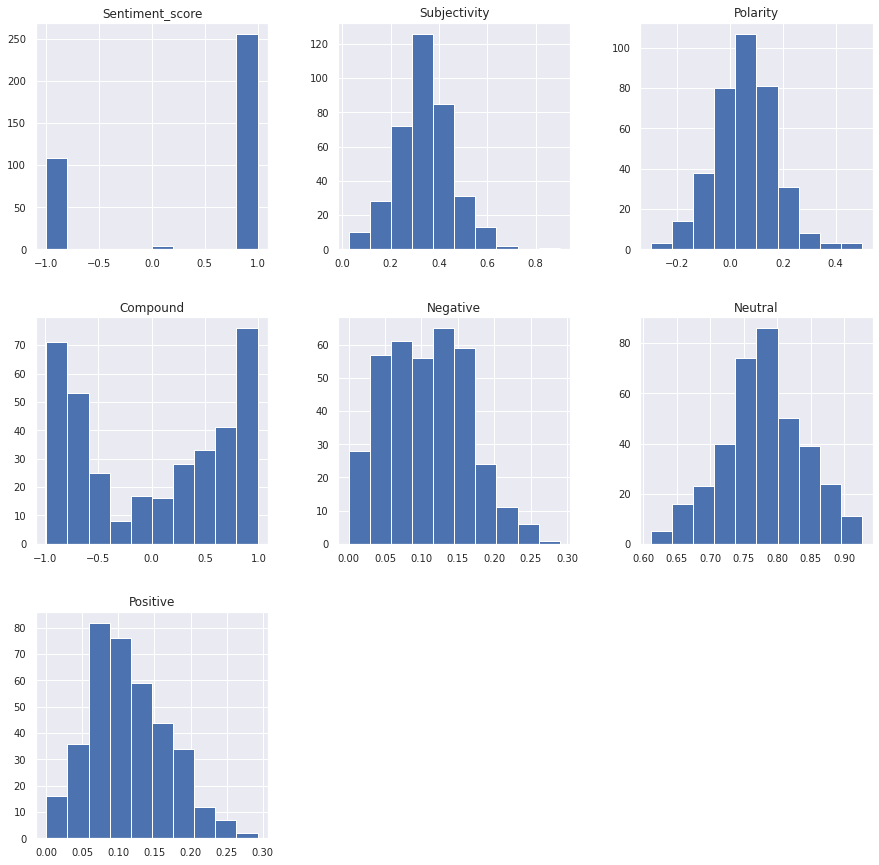

In [14]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()
combined_df.hist(sharex = False, sharey = False, xlabelsize = 10, ylabelsize = 10, figsize=(15, 15))
plt.show()


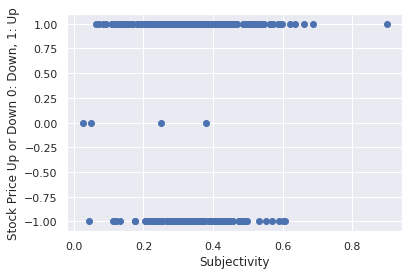

In [15]:
plt.scatter(combined_df['Subjectivity'], combined_df['Sentiment_score'])
plt.xlabel('Subjectivity')
plt.ylabel('Stock Price Up or Down 0: Down, 1: Up')
plt.show()


In [16]:
historical_df = pd.read_csv('/content/drive/MyDrive/Tech_Tailored/goog_historical_data.csv')
historical_df['Date'] = historical_df.Date.astype('datetime64[ns]')
# historical_df.tail()

### Preparing data for forecasting

Merging Headlines data and Historical data for forecasting

In [17]:
merged_df = pd.merge(combined_df,historical_df, on='Date',how='right')
merged_df.rename(columns={'Date':'ds', 'Close':'y'},inplace=True)
merged_df.drop(columns=['Headlines'],inplace=True)
# merged_df.head(2)

In [18]:
# np.mean(merged_df.iloc[:,2:8])

Replacing NaN values with corresponding mean values of respective features

In [19]:
merged_df.Subjectivity.fillna(np.mean(merged_df.Subjectivity),inplace=True)
merged_df.Polarity.fillna(np.mean(merged_df.Polarity),inplace=True)
merged_df.Compound.fillna(np.mean(merged_df.Compound),inplace=True)
merged_df.Negative.fillna(np.mean(merged_df.Negative),inplace=True)
merged_df.Neutral.fillna(np.mean(merged_df.Neutral),inplace=True)
merged_df.Positive.fillna(np.mean(merged_df.Positive),inplace=True)
merged_df.Sentiment_score.fillna(0,inplace=True)


In [20]:
merged_df.head(2)

,ds,Sentiment_score,Subjectivity,Polarity,Compound,Negative,Neutral,Positive,Open,High,Low,y,Adj Close,Volume
0,2018-11-20,-1.0,0.233333,-0.016667,0.051600,0.062000,0.862000,0.076000,1000.00000,1031.739990,996.020020,1025.760010,1025.760010,2449100
1,2018-11-21,0.0,0.339298,0.058482,0.031459,0.105877,0.778754,0.115392,1036.76001,1048.560059,1033.469971,1037.609985,1037.609985,1534300


In [21]:
merged_df.corr()['y']

Sentiment_score    0.122483
Subjectivity      -0.021340
Polarity           0.053012
Compound           0.056705
Negative          -0.081289
Neutral            0.085981
Positive          -0.014787
Open               0.997268
High               0.998633
Low                0.998665
y                  1.000000
Adj Close          1.000000
Volume            -0.031807
Name: y, dtype: float64

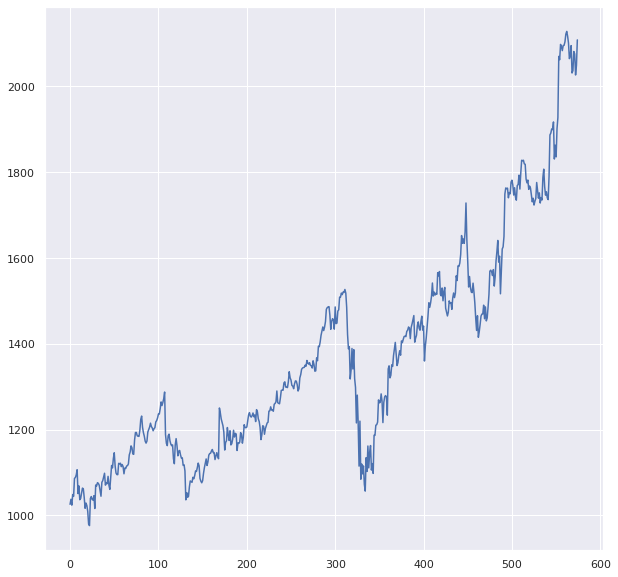

In [22]:
merged_df.y.plot(figsize = (10,10))

In [23]:
df = merged_df[['ds', 'y']]
df.head()

,ds,y
0,2018-11-20,1025.760010
1,2018-11-21,1037.609985
2,2018-11-23,1023.880005
3,2018-11-26,1048.619995
4,2018-11-27,1044.410034


## Stocks forecasting Using FbProphet model

**I** . Only ***Close***

In [24]:
m = Prophet(changepoint_prior_scale=4,changepoint_range=1,n_changepoints=250,holidays_prior_scale=20,)
m.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


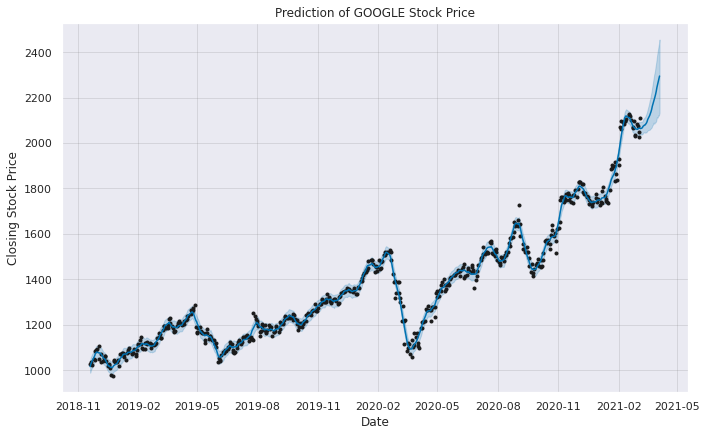

In [25]:
future = m.make_future_dataframe(periods=30)
predictions=m.predict(future)
m.plot(predictions)
plt.title("Prediction of GOOGLE Stock Price")
plt.xlabel("Date")
plt.ylabel("Closing Stock Price")
plt.show()

In [26]:
results_df01 = pd.DataFrame({"ds":future.ds.iloc[:575],"Close":merged_df.y.iloc[:575], 
                             "Predicted":predictions.yhat.iloc[:575]})
results_df01

,ds,Close,Predicted
0,2018-11-20,1025.760010,1015.376729
1,2018-11-21,1037.609985,1026.840296
2,2018-11-23,1023.880005,1040.509886
3,2018-11-26,1048.619995,1057.233874
4,2018-11-27,1044.410034,1064.240450
...,...,...,...
570,2021-03-01,2081.510010,2060.219420
571,2021-03-02,2075.840088,2061.133130
572,2021-03-03,2026.709961,2064.700901
573,2021-03-04,2049.090088,2064.819415


In [27]:
y_true, y_pred = np.array(results_df01.Close), np.array(results_df01.Predicted)
print(np.mean(np.abs((y_true - y_pred) / y_true)) * 100)

1.1382039131737811


**----------------------------------------------------------------------------**

**II**. With all ***news sentiment fearures*** and ***historical features***

Creating two new features namely:
1. New year
2. New month

In [28]:
New_month=[]
for i in pd.DatetimeIndex(merged_df.ds).day:
  if(i>5):
    New_month.append(0)
  else:
    New_month.append(1)

In [29]:
New_year=[]
for i,j in zip(pd.DatetimeIndex(merged_df.ds).day,pd.DatetimeIndex(merged_df.ds).month):
  if(i==31 and j==12):
    New_year.append(1)
    
  elif(i>=1and i<5 and j==1):
    New_year.append(1)

  else:
    New_year.append(0)

In [30]:
merged_df['New_year'] = New_year
merged_df['New_month'] = New_month
merged_df.tail(2)


,ds,Sentiment_score,Subjectivity,Polarity,Compound,Negative,Neutral,Positive,Open,High,Low,y,Adj Close,Volume,New_year,New_month
573,2021-03-04,1.0,0.588788,0.301970,0.458800,0.057000,0.856000,0.088000,2023.369995,2089.239990,2020.270020,2049.090088,2049.090088,2116100,0,1
574,2021-03-05,0.0,0.339298,0.058482,0.031459,0.105877,0.778754,0.115392,2073.120117,2118.110107,2046.415039,2108.540039,2108.540039,2193800,0,1


In [31]:
x_train = merged_df.iloc[:545]
x_test= merged_df.iloc[545:576]

In [32]:
X = x_train[['ds','y','New_year','New_month','Positive','Neutral','Negative']]
X_test = x_test[['y']]

In [33]:
m=Prophet(changepoint_prior_scale=4,changepoint_range=1,n_changepoints=250)
m.add_country_holidays(country_name='US')
m.add_regressor('New_year')
m.add_regressor('New_month')
m.add_regressor('Positive')
m.add_regressor('Negative')
m.add_regressor('Neutral')

In [34]:
m.fit(X)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [35]:
future = m.make_future_dataframe(periods=30)
results_df02 = pd.DataFrame({'ds':future['ds'],
                           'New_year' : merged_df['New_year'].iloc[:575],
                           'New_month' : merged_df['New_month'].iloc[:575],
                           'Positive' : merged_df['Positive'].iloc[:575],
                           'Negative' : merged_df['Negative'].iloc[:575],
                           'Neutral': merged_df['Neutral'].iloc[:575]})

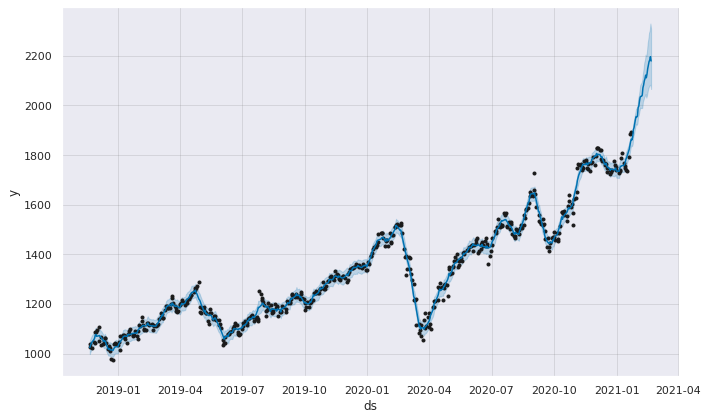

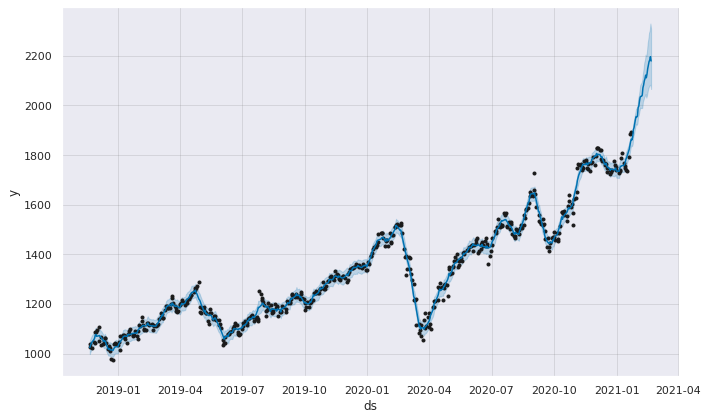

In [36]:
forecast = m.predict(results_df02)
m.plot(forecast)

In [37]:
# fig = m.plot_components(forecast)

In [38]:
pred = pd.DataFrame({'Close':x_test['y'],'Predicted':forecast['yhat'].iloc[545:575],
                     'Yhat_upper':forecast['yhat_upper'].iloc[545:575],
                     'Yhat_lower':forecast['yhat_lower'].iloc[545:575]})

In [39]:
pred

,Close,Predicted,Yhat_upper,Yhat_lower
545,1901.050049,1863.648124,1890.173518,1839.091282
546,1899.400024,1861.289151,1888.596727,1835.487360
547,1917.239990,1872.864390,1901.113818,1845.282318
548,1830.790039,1902.765714,1929.603084,1876.871289
549,1863.109985,1910.784058,1940.685433,1885.834704
550,1835.739990,1927.989705,1958.597008,1900.891335
551,1901.349976,1943.659499,1973.309512,1915.509014
552,1927.510010,1955.429492,1988.148569,1925.761220
553,2070.070068,1953.288014,1986.601762,1921.592567
554,2062.370117,1957.357328,1992.668824,1928.534974


In [40]:
from sklearn.metrics import mean_squared_error
import numpy as np
error=np.sqrt(mean_squared_error(pred['Close'],pred['Predicted']))
error

79.53884891162198

In [41]:
y_true, y_pred = np.array(pred.Close), np.array(pred.Predicted)
print(np.mean(np.abs((y_true - y_pred) / y_true)) * 100)

3.4911568837834723


**--------------------------------------------------------------------------------------------------------------------------------------------------**

**II** . With ***Sentiment_Score,Subjectivity*** & ***Close***

In [42]:
X_train_02 = merged_df.iloc[:545]
x_test_02 = merged_df.iloc[545:576]

In [43]:
X_02 = X_train_02[['ds','y','New_year','New_month','Sentiment_score','Subjectivity']]
X_test_02 = x_test_02[['y']]

In [44]:
X_02.tail()

,ds,y,New_year,New_month,Sentiment_score,Subjectivity
540,2021-01-14,1740.180054,0,0,1.0,0.341667
541,2021-01-15,1736.189941,0,0,0.0,0.339298
542,2021-01-19,1790.859985,0,0,1.0,0.186869
543,2021-01-20,1886.900024,0,0,1.0,0.458788
544,2021-01-21,1891.250000,0,0,1.0,0.281818


In [45]:
m_02 = Prophet(changepoint_prior_scale=4,changepoint_range=1,n_changepoints=250)
m_02.add_country_holidays(country_name='US')
m_02.add_regressor('New_year')
m_02.add_regressor('New_month')
m_02.add_regressor('Sentiment_score')
m_02.add_regressor('Subjectivity')

In [46]:
m_02.fit(X_02)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [47]:
future_02 = m.make_future_dataframe(periods=30)
results_df_03 = pd.DataFrame({'ds':future_02['ds'],
                           'New_year' : merged_df['New_year'].iloc[:575],
                           'New_month' : merged_df['New_month'].iloc[:575],
                           'Sentiment_score' : merged_df['Sentiment_score'].iloc[:575],
                           'Subjectivity' : merged_df['Subjectivity'].iloc[:575]})

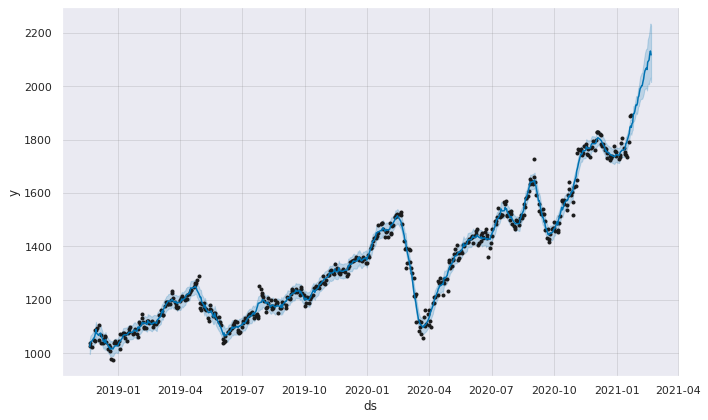

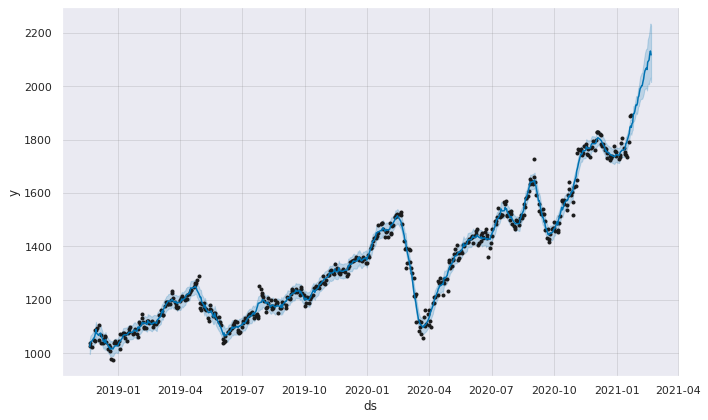

In [48]:
forecast_02 = m_02.predict(results_df_03)

m_02.plot(forecast_02)

In [49]:
# fig_02 = m_02.plot_components(forecast_02)

In [50]:
pred_02 = pd.DataFrame({'Close':X_test_02['y'],'Predicted':forecast_02['yhat'].iloc[545:575],
                     'Yhat_upper':forecast_02['yhat_upper'].iloc[545:575],
                     'Yhat_lower':forecast['yhat_lower'].iloc[545:575]})

pred_02

,Close,Predicted,Yhat_upper,Yhat_lower
545,1901.050049,1845.354749,1873.410410,1839.091282
546,1899.400024,1859.320457,1887.577359,1835.487360
547,1917.239990,1863.283279,1889.284429,1845.282318
548,1830.790039,1896.163415,1925.667016,1876.871289
549,1863.109985,1896.629327,1924.842350,1885.834704
550,1835.739990,1904.484642,1932.951833,1900.891335
551,1901.349976,1919.290939,1948.770509,1915.509014
552,1927.510010,1930.213860,1963.498333,1925.761220
553,2070.070068,1928.150590,1956.949898,1921.592567
554,2062.370117,1937.034916,1968.076722,1928.534974


In [51]:
error=np.sqrt(mean_squared_error(pred_02['Close'],pred_02['Predicted']))
error

80.13349331779233

In [52]:
y_true, y_pred = np.array(pred_02.Close), np.array(pred_02.Predicted)
print(np.mean(np.abs((y_true - y_pred) / y_true)) * 100)

3.2804459187619575


##------------------------------------------------------------------------------------------------------##

### Performing ***Cross Validation***

In [ ]:
df_cv = cross_validation(m, initial='532 days', period='30 days', horizon = '43 days')

INFO:fbprophet:Making 8 forecasts with cutoffs between 2020-05-13 00:00:00 and 2020-12-09 00:00:00


In [ ]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-05-14,1376.751534,1355.091064,1398.065394,1356.130005,2020-05-13
1,2020-05-15,1377.055856,1355.386156,1397.584882,1373.189941,2020-05-13
2,2020-05-18,1368.537210,1344.720269,1391.325817,1383.939941,2020-05-13
3,2020-05-19,1366.324894,1342.092183,1392.813514,1373.484985,2020-05-13
4,2020-05-20,1365.802223,1339.997339,1392.265266,1406.719971,2020-05-13
...,...,...,...,...,...,...
234,2021-01-14,1962.563306,1782.191157,2146.582215,1740.180054,2020-12-09
235,2021-01-15,1962.940387,1774.179864,2162.553664,1736.189941,2020-12-09
236,2021-01-19,1971.145572,1754.051744,2203.961802,1790.859985,2020-12-09
237,2021-01-20,1976.053363,1747.510495,2222.403832,1886.900024,2020-12-09


In [ ]:
from fbprophet.diagnostics import performance_metrics
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,mdape,coverage
0,5 days,4351.164155,65.963355,55.495442,0.034769,0.035390,0.282609
1,6 days,4443.235761,66.657601,54.834599,0.034624,0.027324,0.355072
2,7 days,5643.367751,75.122352,62.060559,0.039070,0.034775,0.304348
3,8 days,7438.244779,86.245259,70.036378,0.043754,0.034775,0.246377
4,9 days,10280.475476,101.392680,82.438336,0.050794,0.045121,0.195652
5,10 days,13055.725617,114.261654,94.212072,0.057640,0.050596,0.130435
6,11 days,17476.861359,132.200081,107.109298,0.066106,0.051422,0.137681
7,12 days,19208.939502,138.596319,111.338953,0.069574,0.051422,0.217391
8,13 days,18024.223820,134.254325,107.680800,0.068396,0.050596,0.231884
9,14 days,22803.542988,151.008420,121.144017,0.077456,0.063031,0.182609


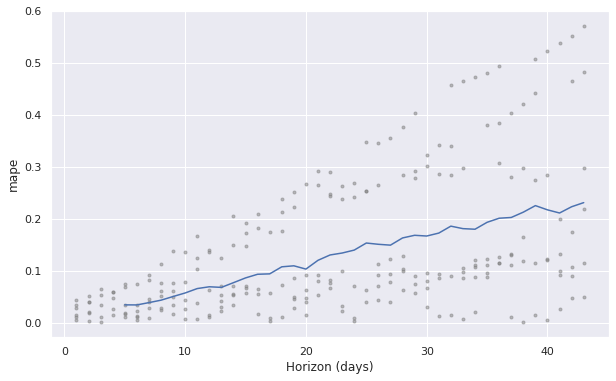

In [ ]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

**-------------------------------------------------------------------------------------------------------**

In [54]:
!pip install chart-studio

     |████████████████████████████████| 71kB 3.0MB/s 


In [55]:
# Import Libraries
import seaborn as sns
import datetime as dt
# Statsmodels widely known for forecasting than Prophet
import statsmodels.api as sm
from scipy import stats
# from pandas import datetools
from plotly import tools
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.tools as tls
import plotly.subplots
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# import warnings
# warnings.filterwarnings("ignore")

# plt.style.available
plt.style.use("seaborn-whitegrid")

start from 2 day 5 day 7 day 10 day 1 month 2 months 3 months 6 months ytd 8 months 1 year trends


In [56]:
merged_df['2_d_avg'] = merged_df.y.rolling(window=2).mean()
merged_df['5_d_avg'] = merged_df.y.rolling(window=5).mean()
merged_df['7_d_avg'] = merged_df.y.rolling(window=7).mean()
merged_df['10_d_avg'] = merged_df.y.rolling(window=10).mean()
merged_df['30_d_avg'] = merged_df.y.rolling(window=30).mean()
merged_df['2_m_avg'] = merged_df.y.rolling(window=60).mean()
merged_df['3_m_avg'] = merged_df.y.rolling(window=90).mean()
merged_df['6_m_avg'] = merged_df.y.rolling(window=180).mean()
merged_df['9_m_avg'] = merged_df.y.rolling(window=270).mean()
merged_df['1_y_avg'] = merged_df.y.rolling(window=365).mean()

close_p = merged_df['y'].values.tolist()


# Variables to insert into plotly
two_d = merged_df['2_d_avg'].values.tolist()
seven_d = merged_df['7_d_avg'].values.tolist()
ten_d = merged_df['10_d_avg'].values.tolist()
thirty_d = merged_df['30_d_avg'].values.tolist()
two_m = merged_df['2_m_avg'].values.tolist()
three_m = merged_df['3_m_avg'].values.tolist()
six_m = merged_df['6_m_avg'].values.tolist()
nine_m = merged_df['9_m_avg'].values.tolist()
one_y = merged_df['1_y_avg'].values.tolist()
date = merged_df['ds'].values.tolist()

# Set date as index
merged_df_mod = merged_df.set_index('ds')

In [57]:
merged_df_mod

,Sentiment_score,Subjectivity,Polarity,Compound,Negative,Neutral,Positive,Open,High,Low,y,Adj Close,Volume,New_year,New_month,2_d_avg,5_d_avg,7_d_avg,10_d_avg,30_d_avg,2_m_avg,3_m_avg,6_m_avg,9_m_avg,1_y_avg
ds,,,,,,,,,,,,,,,,,,,,,,,,,
2018-11-20,-1.0,0.233333,-0.016667,0.051600,0.062000,0.862000,0.076000,1000.000000,1031.739990,996.020020,1025.760010,1025.760010,2449100,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-21,0.0,0.339298,0.058482,0.031459,0.105877,0.778754,0.115392,1036.760010,1048.560059,1033.469971,1037.609985,1037.609985,1534300,0,0,1031.684998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-23,-1.0,0.392235,-0.010038,-0.796400,0.138000,0.768000,0.095000,1030.000000,1037.589966,1022.398987,1023.880005,1023.880005,691500,0,0,1030.744995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-26,0.0,0.339298,0.058482,0.031459,0.105877,0.778754,0.115392,1038.349976,1049.310059,1033.910034,1048.619995,1048.619995,1942800,0,0,1036.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-11-27,0.0,0.339298,0.058482,0.031459,0.105877,0.778754,0.115392,1041.000000,1057.579956,1038.489990,1044.410034,1044.410034,1803200,0,0,1046.515015,1036.056006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-01,1.0,0.141667,0.062500,0.510600,0.029000,0.906000,0.065000,2056.520020,2086.520020,2046.099976,2081.510010,2081.510010,1404500,0,1,2059.184998,2063.152002,2068.825684,2084.918970,1997.760657,1882.193331,1822.242442,1666.292051,1551.403979,1491.004807
2021-03-02,-1.0,0.133333,-0.066667,0.904200,0.035000,0.776000,0.189000,2076.189941,2104.370117,2071.260010,2075.840088,2075.840088,1133600,0,1,2078.675049,2064.147998,2065.211426,2080.312988,2009.082328,1886.324833,1828.019221,1669.973496,1553.732757,1493.315574
2021-03-03,1.0,0.368973,0.070210,-0.077200,0.084000,0.830000,0.086000,2067.209961,2088.518066,2010.000000,2026.709961,2026.709961,1483100,0,1,2051.275025,2050.456006,2059.758580,2070.152979,2016.943994,1889.657166,1832.834775,1673.344940,1555.875276,1495.474478


In [122]:

fig = plotly.subplots.make_subplots(rows=3, cols=1, shared_xaxes=True)

colors = ['#ff4500', '#92a1cf', '#6E6E6E','#9900FF','#FF0044']
avgs = ['2_d_avg', '5_d_avg', '7_d_avg','10_d_avg','30_d_avg']
# for i,c in zip(range(n),color):
#    ax1.plot(x, y,c=c)

for col, c in zip(avgs[0:2], colors[0:2]):
    fig.append_trace({'x': merged_df_mod.index, 'y': merged_df[col], 'type': 'scatter', 'name': col, 'line': {'color': c}}, 1, 1)
for col, c in zip(avgs[2:5], colors[2:5]):
    fig.append_trace({'x': merged_df_mod.index, 'y': merged_df[col], 'type': 'scatter', 'name': col, 'line': {'color': c}}, 2, 1)
for col in ['y']:
    fig.append_trace({'x': merged_df_mod.index, 'y': merged_df[col], 'type': 'scatter', 'name': 'Closing Price', 'line':{'color': '#01DF3A'}}, 3, 1)
    
fig['layout'].update(height=800,title='Relationship between MAs <br> and Closing Price',
                    paper_bgcolor='#F2DFCE', plot_bgcolor='#F2DFCE')
    
iplot(fig,show_link=True, filename='pandas/mixed-type subplots.html',animation_opts={'frame':{'duration':5}})